# Dataset Information:


> **URL**: https://www.kaggle.com/snap/amazon-fine-food-reviews


> **About**: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

>**Data Includes**:
    Reviews from Oct 1999 - Oct 2012; 
    568,454 reviews; 
    256,059 users; 
    74,258 products; 
    260 users with > 50 reviews. 

---



---


> **Problem Statement**: You need to create a model which predicts the sentiments of customers as "Positive" or "Negative" based on the Comments the users have written for each product.










# Importing necessary modules

In [0]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import nltk
from datetime import datetime
import re
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer   #for BOW
from sklearn.feature_extraction.text import TfidfVectorizer   #for tfidf

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import SGDClassifier


import warnings
warnings.filterwarnings("ignore")

In [3]:
#--------------------Run this cell to mount your Google Drive-------------------
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
sns.set_style("whitegrid")

# Data Pre-Processing

In [5]:
data = pd.read_csv('/content/drive/My Drive/ER/Text Mining/Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.shape

(568454, 10)

In [0]:
def partition(score): 
  '''
  Function: Function to assign "positive" if score >3 else "negative" to labels.

  Parameter:
  score - It is the Y label.
  '''
  
  if score>3:
    return "positive"
  else:
    return "negative"
  

score = data["Score"]
reviews = score.map(partition)
data["Reviews"] = reviews

In [8]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Reviews
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [0]:
#Random Sampling 10000 positive and 10000 negative datapoints from dataframe.

df_p = data[data["Reviews"]=="positive"].sample(10000)
df_n = data[data["Reviews"]=="negative"].sample(10000)

In [0]:
#This is the final dataframe. It contains 10000 +ve values and 10000 -ve values
frames = [df_p, df_n]
df = pd.concat(frames)

In [0]:
#Cleaning the data
#Removing Id, dropping duplicate entries, and tajeing a constraint where total no. of votes is always greater than total no of upvodes for a given review
df = df.drop(labels = "Id", axis = 1)
df = df.drop_duplicates(subset = ["UserId","ProfileName","Summary","Text"])
df = df[df["HelpfulnessNumerator"]<=df["HelpfulnessDenominator"]]

In [0]:
#Converting from timestamp to datetime object.

from datetime import datetime
Time = []
for i in list(df["Time"]):
  Time.append(datetime.fromtimestamp(i).strftime('%d-%m-%Y'))
  
df["Time"] = pd.to_datetime(Time)
df = df.sort_values("Time")       #Sorting the dataframe according to datetime

In [13]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Reviews
451859,B00004CXX9,AZRJH4JFB59VC,Lynwood E. Hines,21,23,1,2001-08-08,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,negative
230257,B00004RYGX,AEPJYN0NAX9N4,Jody L. Schoth,0,0,5,2002-02-20,Excellent... Hilarious,Just hilarious... my favorite part is the dini...,positive
479729,B00005U2FA,A7BP01VQO33U,Caleb,11,11,5,2002-05-23,Way To Go Guys!,I'm never dissapointed with the great gadgets ...,positive
451848,B00004CXX9,A1JZV9MCT6KOX4,"C. Eallonardo ""Kali's Copilot""",0,0,5,2002-11-22,Good Tim Burton Flick,I like Tim Burton movies in general. But this...,positive
230267,B00004RYGX,A10L8O1ZMUIMR2,G. Kleinschmidt,61,79,2,2002-12-27,Great movie turned bad,"Just to let you know, this movie is one of my ...",negative


# To clean the text in a representable form

In [0]:
import re

In [15]:
#To check whether the sentences have html tags or not
i=0;
for sent in df['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1; 

0
I am continually amazed at the shoddy treatment that some movies get in their DVD release.  This DVD is simply a disgrace, especially considering what a great movie this is.  I give the movie itself 5 stars; it's a wonderful example of Tim Burton's energy and style.<p>This DVD has no extras worth mentioning.  No deleted scenes, no featurettes, not even a lousy commentary track!  To make it even worse, the film has been CUT DOWN from the theatrical release!  I have never seen a DVD release before where you get LESS than was originally presented in theaters.<p>My advice is to save your money until somebody figures out that when a movie is released on DVD, it needs to live up to the capabilities of the medium, and should always provide more material than was originally released, not less.


In [0]:
#Cleaning HTML tags and punctuaions from each review using functions

def html(a):                                #Cleaning HTML Tags
  html = re.sub(r'<.*?>', " ",a )
  return html

def repl_punc(b):                           #Cleaning punctuations
  cleaned1 = re.sub(r'[?|!|\'|"|#]', " ",b)
  cleaned = re.sub(r'[.|,|)|(|\|/]', " ", cleaned1)
  return cleaned

In [17]:
#  Creating a set of Stop words

nltk.download('stopwords')
from nltk.corpus import stopwords
sw = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Using SnowBall stemmers to find the root words

from nltk.stem.snowball import SnowballStemmer
snow = SnowballStemmer("english")

In [0]:
#Taking a sentence and converting it to words

f_str = []
z=0
c=[]
positive = []
negative = []
for sen in df["Text"]:
  
  sen_html = html(sen)
  a = repl_punc(sen_html).split()
  temp=[]
  for words in a:
      if (words.lower()).isalpha():
        if words.lower() not in sw:
          stem_word = (snow.stem(words.lower()))#.encode('utf8')
          temp.append(stem_word)
          if (df["Reviews"].values)[z]=="positive":
            positive.append(stem_word)
          else:
            negative.append(stem_word) 
        else:
          continue
      else:
        continue
   
  c.append(temp)
  z+=1
  
for i in c:
  str2 = " ".join(i)
  f_str.append(str2)
  

df["F_review"] = f_str  

In [20]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Reviews,F_review
451859,B00004CXX9,AZRJH4JFB59VC,Lynwood E. Hines,21,23,1,2001-08-08,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,negative,continu amaz shoddi treatment movi get dvd rel...
230257,B00004RYGX,AEPJYN0NAX9N4,Jody L. Schoth,0,0,5,2002-02-20,Excellent... Hilarious,Just hilarious... my favorite part is the dini...,positive,hilari favorit part dine room scene sing danc ...
479729,B00005U2FA,A7BP01VQO33U,Caleb,11,11,5,2002-05-23,Way To Go Guys!,I'm never dissapointed with the great gadgets ...,positive,never dissapoint great gadget compani come bro...
451848,B00004CXX9,A1JZV9MCT6KOX4,"C. Eallonardo ""Kali's Copilot""",0,0,5,2002-11-22,Good Tim Burton Flick,I like Tim Burton movies in general. But this...,positive,like tim burton movi general good one movi fun...
230267,B00004RYGX,A10L8O1ZMUIMR2,G. Kleinschmidt,61,79,2,2002-12-27,Great movie turned bad,"Just to let you know, this movie is one of my ...",negative,let know movi one person favorit ghost movi sa...


In [0]:
#Function to label 1 to positive reviews and 0 to negative reviews
def y_label():
  label = []
  for i in df["Score"]:
    if i>3:
      label.append(1)
    else:
      label.append(0)
  return label

# Data Exploration

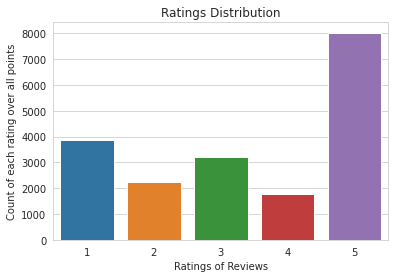

In [22]:
#Distribution of Ratings

ax = plt.axes()
sns.countplot(df.Score, ax = ax)
ax.set_title("Ratings Distribution")
plt.xlabel("Ratings of Reviews")
plt.ylabel("Count of each rating over all points")
plt.show()

In [23]:
r = len(df[df["Score"]==1]) + len(df[df["Score"]==5])
percent = r/len(df)
print("Percentage of 1 star and 5 star rating: ", percent*100, "%")

Percentage of 1 star and 5 star rating:  62.32582503928759 %


##Observation - 
1)We observe that 1 and 5 star rating reviews are more than 50% of the total ratings.

In [0]:
#Count of Helpful Ratings vs Rating of Reviews

#"Helpful_ratio" - the more is the ratio, the more is the review revelant or helpful.
#Assigning value of '-1' to all those review whose total votes and upvotes are equal and less than 6.
ar = []
for i in df.index:
  if(df["HelpfulnessDenominator"][i] == df["HelpfulnessNumerator"][i] and df["HelpfulnessNumerator"][i] <6 ):
    ar.append((-1))
  else:
    ar.append(df["HelpfulnessNumerator"][i]/df["HelpfulnessDenominator"][i])
    
    
df["Helpful_ratio"] = ar  

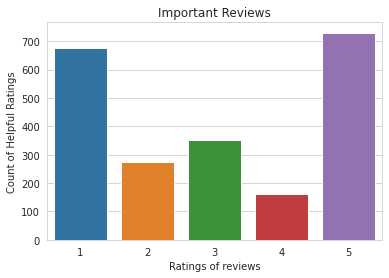

In [25]:
#Plotting graph for all the reviews which has a "Helpful_ratio" > 0.6
ax = plt.axes()
sns.countplot(x = df[df["Helpful_ratio"]>0.6]["Score"], ax = ax)
ax.set_title("Important Reviews")
plt.xlabel("Ratings of reviews")
plt.ylabel("Count of Helpful Ratings")
plt.show()

## Observation - 
Helpful ratio = HelpfulnessNumerator / HelpfulnessDenominator

"Helpful_ratio" - the more is the ratio, the more is the review relevant or helpful.

1)It can be seen that most of the most relevant reviews belong to ratings 1 and 5.

In [0]:

L = []
for i in df["F_review"].values:
  L.append(len(i))
df["Length"] = L

Text(0, 0.5, 'Count of word per document')

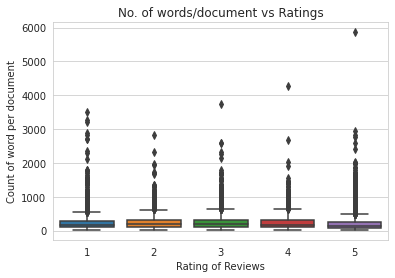

In [27]:
ax = plt.axes()
sns.boxplot(x = "Score", y = "Length", data = df)
ax.set_title("No. of words/document vs Ratings")
plt.xlabel("Rating of Reviews")
plt.ylabel("Count of word per document")

In [28]:
print("Median of the count of words for rating 1: ",df[df["Score"]==1]["Length"].median())
print("Median of the count of words for rating 2: ",df[df["Score"]==2]["Length"].median())
print("Median of the count of words for rating 3: ",df[df["Score"]==3]["Length"].median())
print("Median of the count of words for rating 4: ",df[df["Score"]==4]["Length"].median())
print("Median of the count of words for rating 5: ",df[df["Score"]==5]["Length"].median())

Median of the count of words for rating 1:  173.0
Median of the count of words for rating 2:  185.0
Median of the count of words for rating 3:  185.0
Median of the count of words for rating 4:  180.0
Median of the count of words for rating 5:  146.0


##Observations-
1) We can see that median values of all the ratings is less than 200 words per document.

2) There are a lot of outlier ratings with a word range from 1000 to 3000. 

Text(0.5, 1.0, 'Positive vs Negative Reviews')

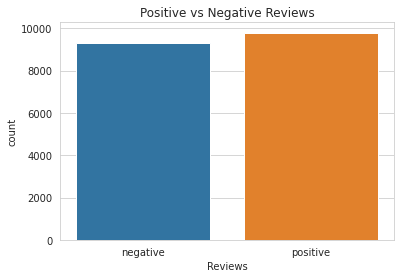

In [29]:
#Positive vs Negative Reviews

ax = plt.axes()
sns.countplot(x = "Reviews", data = df)
ax.set_title("Positive vs Negative Reviews")

In [0]:
#Word Cloud

i = 0
p = []                                   #Seperating positive and negative Reviews
n = []
for sent in df["F_review"].values:
  for words in sent.split():
    if(df["Reviews"].values[i]=="positive"):
      p.append(words)
    else:
      n.append(words)
  i+=1  

Text(0.5, 0, 'Most used words in Positive Reviews')

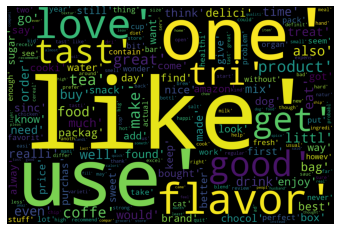

In [31]:
#Positive words Word Cloud

wc = WordCloud(width = 1500, height = 1000).generate(str(p))
plt.axis("off")
plt.imshow(wc)
plt.xlabel("Most used words in Positive Reviews")

##Observations -
1) Words like - "like", "use", "one", "good" etc are common in positive documents. These would be the most common words used to describe how good the food is.

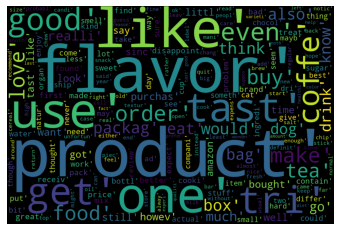

In [32]:
#Negative words Word Cloud

wc = WordCloud(width = 1500, height = 1000).generate(str(n))
plt.axis("off")
plt.imshow(wc)

##Observations -
1) Words like - "like", "flavor", "one", "product" etc are common in negative documents.

2)We can see various words appear in both the word clouds. One probable reason could be that these words appear with stop words like "not", "didnt" etc, but I removed the stopwords before and hence they are not appearing in word cloud.

# Bag Of Words (BOW)

In [0]:
def BOW():
  '''
  Function: This function uses a Bag of Words Vectorizer with Bi-gram and Tri-gram
  Returns: Returns the Bag of Words Vectorized Data and Label.
  '''
  
  bow = CountVectorizer(ngram_range = (2,3))
  bow_sparse = bow.fit_transform(df["F_review"].values)

  X_bow = bow_sparse
  y_bow = y_label()
  return X_bow, y_bow

# Term Frequency - Inverse Document Frequency (TF-IDF)

In [0]:
def tfidf():
  '''
  Function: This function uses a TFIDF Vectorizer with Bi-gram and Tri-gram
  Returns: Returns the Tfidf Vectorized Data and Label
  '''
  
  tfidf_vect = TfidfVectorizer(ngram_range = (2,3))
  tfidf_ngrams = tfidf_vect.fit_transform(df["Text"].values)

  X_tfidf = tfidf_ngrams
  y_tfidf = y_label()
  return X_tfidf, y_tfidf

# Train and Test Functions

In [0]:
def training(X_train,y_train, params, model):
  '''
  Function: This function is used for Training the model passed with the given 
            data parameters. Then it finds out the best parameters for the model.

  Parameters:
  X_train - Training Data
  y_train - Training Label
  params - List of Parameters for the used algorithms.
  model - Passing the model to be used for training. 
  '''
  
  RS = RandomizedSearchCV(model, params,refit = 'accuracy', cv = 5, random_state = 42, scoring = ['accuracy', 'f1', 'roc_auc'])
  RS.fit(X_train, y_train)
  cv_results = pd.DataFrame(RS.cv_results_)
  best_param = RS.best_params_

  return best_param

In [0]:
def testing(X_train,y_train,X_test,y_test,model,vectorizer):
  '''
  Function: This function retrains the model with the best parameters found in
            Training phase.
  
  Parameters:
  X_train - Training Data
  y_train - Training Label
  X_test - Testing Data
  y_test - Testing Label
  model - Passing the model to be used for training.
  vectorizer - The method used for Vectorizing the data.
  '''
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print("Accuracy Score for ",vectorizer,": ",accuracy_score(y_test,y_pred))
  print("ROC for ",vectorizer,": ",roc_auc_score(y_test,y_pred))
  print("Confusion Matrix for ", vectorizer,":") 
  print(confusion_matrix(y_test,y_pred))

# Implementing KNN

In [37]:
##---------Implementing KNN Algorithm-----------

#BOW()  --training
print("------------Training Started------------")
X,y = BOW()
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42,train_size = 0.7)
params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]}
model = KNeighborsClassifier(algorithm = 'brute')
best_param = training(X_train,y_train,params,model)
best_k = best_param["n_neighbors"]
print("-----------Training Ended------------")
print("")

#BOW()  --testing
print("-----------Testing Started------------")
model = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'kd_tree')
testing(X_train,y_train,X_test,y_test,model, "BOW")
print("/n-----------Testing Ended-------------")
print("")
print("-----------------********************------------------*****************-----------------")
print("")

#TFIDF()  --training
print("------------Training Started------------")
X,y = tfidf()
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42,train_size = 0.7)
params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]}
model = KNeighborsClassifier(algorithm = 'brute')
best_param = training(X_train,y_train,params,model)
best_k = best_param["n_neighbors"]
print("-----------Training Ended------------")
print("")

#TFIDF()  --testing
print("-----------Testing Started------------")
model = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'kd_tree')
testing(X_train,y_train,X_test,y_test,model, "TFIDF")
print("-----------Testing Ended-------------")

------------Training Started------------
-----------Training Ended------------

-----------Testing Started------------
Accuracy Score for  BOW :  0.5205168500087306
ROC for  BOW :  0.5070471219908728
Confusion Matrix for  BOW :
[[  94 2688]
 [  58 2887]]
/n-----------Testing Ended-------------

-----------------********************------------------*****************-----------------

------------Training Started------------
-----------Training Ended------------

-----------Testing Started------------
Accuracy Score for  TFIDF :  0.78452942203597
ROC for  TFIDF :  0.7838275159618161
Confusion Matrix for  TFIDF :
[[2112  670]
 [ 564 2381]]
-----------Testing Ended-------------


# Implementing Random Forest

In [38]:
##---------Implementing RF Algorithm-----------

#BOW()  --training
print("------------Training Started------------")
X,y = BOW()
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42,train_size = 0.7)
params = {"max_depth":[10,20,30],
          "n_estimators": [100,200]
         }
model = RandomForestClassifier()
best_param = training(X_train,y_train,params,model)
best_depth = best_param["max_depth"]
best_estimator = best_param["n_estimators"]
print("-----------Training Ended------------")
print("")

#BOW()  --testing
print("-----------Testing Started------------")
model = RandomForestClassifier(max_depth = best_depth, n_estimators = best_estimator)
testing(X_train,y_train,X_test,y_test,model, "BOW")
print("/n-----------Testing Ended-------------")
print("")

print("-*"*100)
print("")

#TFIDF()  --training
print("------------Training Started------------")
X,y = tfidf()
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42,train_size = 0.7)
params = {"max_depth":[10,20,30],
          "n_estimators": [100,200]
         }
model = RandomForestClassifier()
best_param = training(X_train,y_train,params,model)
best_depth = best_param["max_depth"]
best_estimator = best_param["n_estimators"]
print("-----------Training Ended------------")
print("")

#TFIDF()  --testing
print("-----------Testing Started------------")
model = RandomForestClassifier(max_depth = best_depth, n_estimators = best_estimator)
testing(X_train,y_train,X_test,y_test,model, "TFIDF")
print("-----------Testing Ended-------------")

------------Training Started------------
-----------Training Ended------------

-----------Testing Started------------
Accuracy Score for  BOW :  0.6263314126069496
ROC for  BOW :  0.6168071119334944
Confusion Matrix for  BOW :
[[ 785 1997]
 [ 143 2802]]
/n-----------Testing Ended-------------

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

------------Training Started------------
-----------Training Ended------------

-----------Testing Started------------
Accuracy Score for  TFIDF :  0.7595599790466213
ROC for  TFIDF :  0.755888387511763
Confusion Matrix for  TFIDF :
[[1744 1038]
 [ 339 2606]]
-----------Testing Ended-------------


# Implementing Logistic Regression

In [39]:
##---------Implementing Logistic Regression Algorithm-----------

#BOW()  --training
print("------------Training Started------------")
X,y = BOW()
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42,train_size = 0.7)
params = {"alpha":[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
          "penalty": ["l1", "l2"]
         }
model = SGDClassifier(loss = "log")
best_param = training(X_train,y_train,params,model)
best_alpha = best_param["alpha"]
best_penalty = best_param["penalty"]
print("-----------Training Ended------------")
print("")

#BOW()  --testing
print("-----------Testing Started------------")
model = SGDClassifier(alpha = best_alpha, penalty = best_penalty, loss = "log")
testing(X_train,y_train,X_test,y_test,model, "BOW")
print("/n-----------Testing Ended-------------")
print("")
print("-*"*100)
print("")

#TFIDF()  --training
print("------------Training Started------------")
X,y = tfidf()
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42,train_size = 0.7)
params = {"alpha":[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
          "penalty": ["l1", "l2"]
         }
model = SGDClassifier(loss = "log")
best_param = training(X_train,y_train,params,model)
best_alpha = best_param["alpha"]
best_penalty = best_param["penalty"]
print("-----------Training Ended------------")
print("")

#TFIDF()  --testing
print("-----------Testing Started------------")
model = SGDClassifier(alpha = best_alpha, penalty = best_penalty, loss = "log")
testing(X_train,y_train,X_test,y_test,model, "TFIDF")
print("-----------Testing Ended-------------")

------------Training Started------------
-----------Training Ended------------

-----------Testing Started------------
Accuracy Score for  BOW :  0.7679413305395495
ROC for  BOW :  0.766872838853703
Confusion Matrix for  BOW :
[[2029  753]
 [ 576 2369]]
/n-----------Testing Ended-------------

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

------------Training Started------------
-----------Training Ended------------

-----------Testing Started------------
Accuracy Score for  TFIDF :  0.8423258250392875
ROC for  TFIDF :  0.842033860654047
Confusion Matrix for  TFIDF :
[[2314  468]
 [ 435 2510]]
-----------Testing Ended-------------



# Conclusion -
1) As we can see that Logistic Regression is giving an AUC score of 0.8420 ~ 84.2% for Tfidf Vectorizer. Hence We choose Tfidf Vetorizer with Logistic Regression as the preffered model.